In [1]:
import numpy as np
import scipy.io as scio # load mat file
from scipy.signal import welch, filtfilt
from scipy.interpolate import interp1d

from PSO import *  # demo PSO codes!

import matplotlib.pyplot as plt

In [2]:
# load data
TrainingData = scio.loadmat('../generate_ligo/noise.mat') # only noise    
analysisData = scio.loadmat('../generate_ligo/data.mat') # noise + signal
# analysisData = scio.loadmat('TrainingData.mat') # only noise to check

## Preparing
# dataY = analysisData['dataVec'][0] # (2048,)
dataY = analysisData['data'][0]
# dataY = analysisData['trainData'][0] # (2048,)1
# Data length
nSamples = dataY.size # 2048
# Sampling frequency
# Fs = analysisData['sampFreq'][0,0] # 1024
Fs = analysisData['samples'][0]
# Fs = 1024

# Search range of phase coefficients
"""
        r   m1  m2   tc   phi_c   DL  DLS   zl  v  omega  y
        r = r * 1e8 * pc
        m1,m2 = m1,m2 *m_sun
        DL,DLS = DL,DLS * 1e6 * pc
        v = v * 1e6
"""
rmin = [0.8, 4 , 4 ,-1 , -2*np.pi,10,  10  ,0, 0.8,0   ,-1]
rmax = [1.2, 35, 35, 1 , 2*np.pi,1000, 1000,2, 1.2,1000, 1]

# Noise realization: PSD estimated from TrainingData
dt = 1/Fs
# t = np.arange(0, nSamples*dt, dt) # (2048,)
t = np.linspace(-10,0,nSamples)
T = nSamples/Fs
df = 1/T
Nyq = Fs/2 # Nyquist frequency
[f, pxx] = welch(TrainingData['noise'][0], fs=Fs, 
                 window='hamming', nperseg=Fs/2, 
                 noverlap=None, nfft=None, 
                 detrend=False) 
# Why 'detrend=False'? 
# See https://github.com/scipy/scipy/issues/8045#issuecomment-337319294
# or https://iphysresearch.github.io/blog/post/signal_processing/spectral_analysis_scipy/

# Smooth the PSD estimate
smthOrdr = 10
b = np.ones(smthOrdr)/smthOrdr
pxxSmth = filtfilt(b,1,pxx)
# PSD must be supplied at DFT frequencies.
kNyq = np.floor(nSamples/2) + 1
posFreq = np.arange(0, kNyq)*Fs/nSamples
psdPosFreq = interp1d(f,pxxSmth)(posFreq)

/home/ywq/anaconda3/envs/PSOlinux/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:462: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


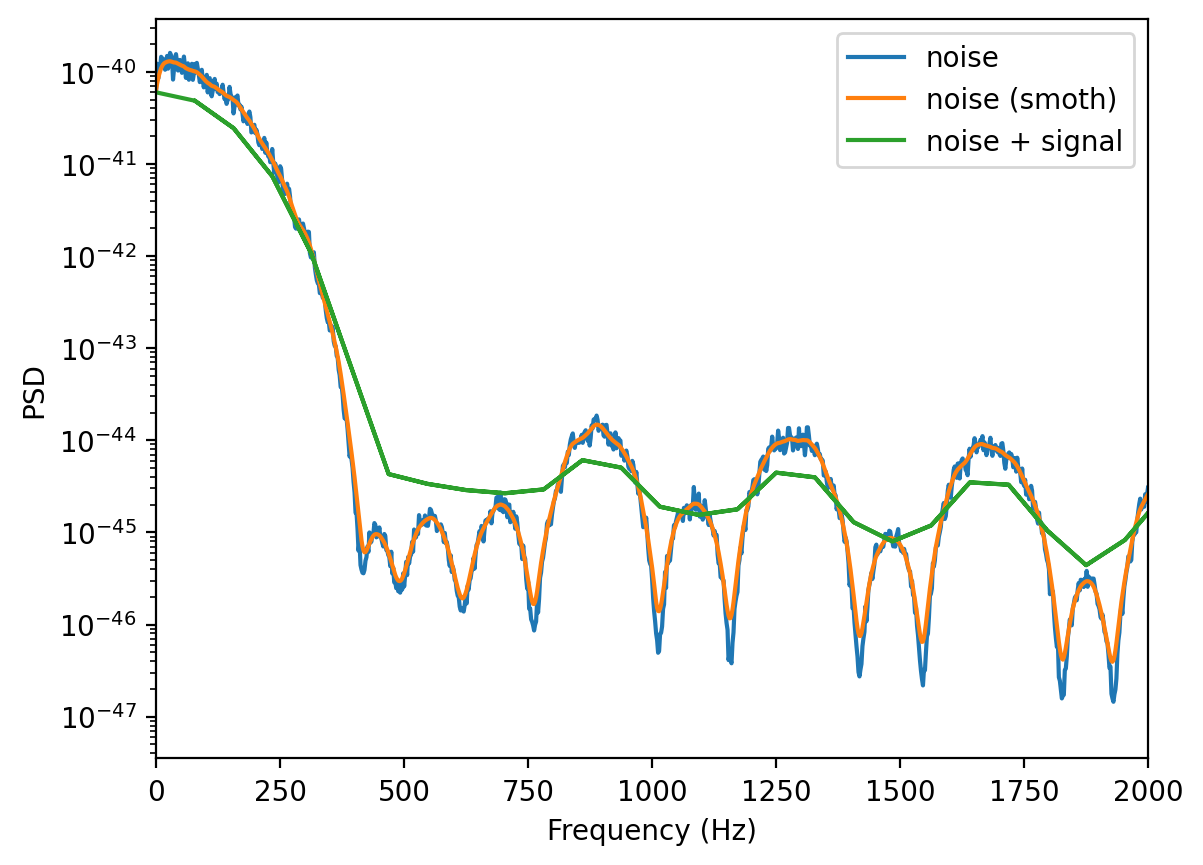

In [3]:
# Plot PSDs for the noise and noise + signal.
plt.figure(dpi=200)
plt.plot(f,pxx, label='noise')
plt.plot(f,pxxSmth, label='noise (smoth)')
[f, pxxY] = welch(dataY, fs=Fs, 
                 window='hamming', nperseg=256, 
                 noverlap=None, nfft=None, 
                 detrend=False)
plt.plot(np.abs(f),pxxY, label='noise + signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.yscale('log')
plt.xlim(0,2000)
plt.legend()
plt.savefig('output_psd.png', dpi=200)
plt.show()

In [4]:
# Number of independent PSO runs
nRuns = 4

In [5]:
## PSO
# Input parameters for CRCBQCHRPPSO
inParams = {
    'dataX': t,
    'dataY': dataY,
    'dataXSq': t**2,
    'dataXCb': t**3,
    'psdPosFreq': psdPosFreq,
    'sampFreq': Fs,
    'rmin': rmin,
    'rmax': rmax,
}
# CRCBQCHRPPSOPSD runs PSO on the CRCBQCHRPFITFUNC fitness function. As an
# illustration of usage, we change one of the PSO parameters from its
# default value.
outResults, outStruct = crcbqcpsopsd(inParams, {'maxSteps': 100}, nRuns)

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

/home/ywq/PSO_change/PSO_change/PSO_python_demo-main/PSO.py:333: RuntimeWarning: invalid value encountered in sqrt
  F_geo = np.sqrt(1 + 1/y) - 1j * np.sqrt(-1 + 1 / y) * np.exp(1j * w * 2 * y)
/home/ywq/PSO_change/PSO_change/PSO_python_demo-main/PSO.py:335: RuntimeWarning: invalid value encountered in power
  sigVec = G * M_c / (c ** 2 * r) * theta_t ** (-1/4) *np.cos(2 * phi_c - 2 * theta_t ** (5/8)) * F_geo
/home/ywq/PSO_change/PSO_change/PSO_python_demo-main/PSO.py:435: RuntimeWarning: invalid value encountered in divide
  innProd = np.sum((1/dataLen) * (fftX / psdVec4Norm)*fftY.conj())
/home/ywq/PSO_change/PSO_change/PSO_python_demo-main/PSO.py:335: RuntimeWarning: invalid value encountered in power
  sigVec = G * M_c / (c ** 2 * r) * theta_t ** (-1/4) *np.cos(2 * phi_c - 2 * theta_t ** (5/8)) * F_geo


/home/ywq/PSO_change/PSO_change/PSO_python_demo-main/PSO.py:336: RuntimeWarning: invalid value encountered in divide
  sigV

ValueError: too many values to unpack (expected 2)

In [ ]:
## Plots
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
a=ax.scatter(t, dataY, marker='.', s=5, #label='analysisData'
             )
a.set_label('analysisData')
for lpruns in range(nRuns):
    b,=ax.plot(t, outResults['allRunsOutput'][lpruns]['estSig'],
             color=[51/255,255/255,153/255], lw=.4*2)
b.set_label('estSig')
c,=ax.plot(t, outResults['bestSig'], #label='BestSig',
         color=[76/255,153/255,0/255],lw=.2*2)
c.set_label('BestSig')
plt.legend()
plt.savefig('output_sig.png', dpi=200)
plt.show()
print(outResults['allRunsOutput'][lpruns]['estSig'])

In [ ]:
# Print estimated parameters
print('Estimated parameters:')
print('r = {:.4e} pc'.format(outResults['r']))
print('m1 = {:.4e} M_sun'.format(outResults['m1']))
print('m2 = {:.4e} M_sun'.format(outResults['m2']))
print('tc = {:.4f}'.format(outResults['tc']))
print('phi_c = {:.4f}'.format(outResults['phi_c']))
print('DL = {:.4e} pc'.format(outResults['DL']))
print('DLS = {:.4e} pc'.format(outResults['DLS']))
print('zl = {:.4f}'.format(outResults['zl']))
print('v = {:.4e} m/s'.format(outResults['v']))
print('omega = {:.4f}'.format(outResults['omega']))
print('y = {:.4f}'.format(outResults['y']))

for lpruns in range(nRuns):
    print('\nRun No.{}:'.format(lpruns+1))
    print('bestFitness={:.2f}'.format(outStruct[lpruns]['bestFitness']))
    print('r = {:.4e} pc'.format(outResults['allRunsOutput'][lpruns]['r']))
    print('m1 = {:.4e} M_sun'.format(outResults['allRunsOutput'][lpruns]['m1']))
    print('m2 = {:.4e} M_sun'.format(outResults['allRunsOutput'][lpruns]['m2']))
    print('tc = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['tc']))
    print('phi_c = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['phi_c']))
    print('DL = {:.4e} pc'.format(outResults['allRunsOutput'][lpruns]['DL']))
    print('DLS = {:.4e} pc'.format(outResults['allRunsOutput'][lpruns]['DLS']))
    print('zl = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['zl']))
    print('v = {:.4e} m/s'.format(outResults['allRunsOutput'][lpruns]['v']))
    print('omega = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['omega']))
    print('y = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['y']))

# Save
np.save('output_results',outResults)
np.save('output_struct',outStruct)